# Dependências

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 53kB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification, make_regression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

%matplotlib inline

print(tf.__version__)

2.3.1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#@title
def plot_random_batch(batch, y_true, y_pred=None, batch_size=30, n_cols=10, figsize=(20, 10)):
    plt.figure(figsize=figsize)

    random_idx = np.random.choice(batch.shape[0], size=batch_size)
    x_batch = batch[random_idx].squeeze()
    y_batch = y_true[random_idx]
    
    y_pred = y_batch if y_pred is None else y_pred[random_idx]
    n_rows = x_batch.shape[0] // n_cols + 1
    is_gray = (batch.shape[-1] == 1 or batch.ndim == 3)
    for img, true, pred, sub in zip(x_batch, y_batch, y_pred, range(1, len(batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8), cmap='gray' if is_gray else None)
        
        plt.title("T:{} P:{}".format(true, pred), color = 'green' if true == pred else 'red')
        plt.axis('off')
    plt.tight_layout()
    
def make_cubic(n_samples, x_min, x_max, a=1, b=0, c=0, d=0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = a*x**3 + b*x**2 + c*x + d + (2*noise*np.random.random(n_samples) - noise)
    return x.reshape(-1,1), y.reshape(-1,1)

def make_exp(n_samples, x_min, x_max, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = np.exp(x) + 2*noise*np.random.random(n_samples) - noise
    return x.reshape(-1,1), y.reshape(-1,1)
    
def make_log10(n_samples, x_min, x_max, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.logspace(np.log10(x_min), np.log10(x_max), n_samples)
    y = np.log10(x) + 2*noise*np.random.random(n_samples) - noise
    return x.reshape(-1,1), y.reshape(-1,1)

def make_square(n_samples, x_min, x_max, a=1, b=0, c=0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = a*x**2 + b*x + c + (2*noise*np.random.random(n_samples) - noise)
    return x.reshape(-1,1), y.reshape(-1,1)
    
def make_spiral(n_samples, n_class=2, radius=1, laps=1.0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.zeros((n_samples * n_class, 2))
    y = np.zeros((n_samples * n_class))
    
    pi_2 = 2 * np.math.pi
    points = np.linspace(0, 1, n_samples)
    r = points * radius
    t = points * pi_2 * laps
    for label, delta_t in zip(range(n_class), np.arange(0, pi_2, pi_2/n_class)):
        random_noise = (2 * np.random.rand(n_samples) - 1) * noise
        index = np.arange(label*n_samples, (label+1)*n_samples)
        x[index] = np.c_[r * np.sin(t + delta_t) + random_noise,
                         r * np.cos(t + delta_t) + random_noise]
        y[index] = label
    return x, y.reshape(-1, 1)
  
def __softmax(x):
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def __compute_meshgrid(x, y):
    x_min, x_max, y_min, y_max = x[:, 0].min(), x[:, 0].max(), x[:, 1].min(), x[:, 1].max()
    x1, x2 = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    x_mesh = np.array([x1.ravel(), x2.ravel()]).T
    return x1, x2, x_mesh

def plot_hist_and_predictions(history, x, y, model, s=15, cmap=plt.cm.viridis):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    ax = plt.subplot(1, 2, 2)
    plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)

    plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
    x1, x2, x_mesh = __compute_meshgrid(x, y)
    y_mesh = model.predict_classes(x_mesh)
    plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)
    plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap=cmap, alpha=0.5)
    
def plot_hist_and_line(history, x, y, model):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.subplot(1, 2, 2)
    x_test = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_test)
    plt.scatter(x, y)
    plt.plot(x_test, y_pred, color='green')
    plt.xlabel('x')
    plt.ylabel('y')

# Regressão

## Regressão Linear

In [ ]:
x, y = make_regression(n_samples=100, n_features=1, noise=15, random_state=42)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x, y)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, activation="linear", input_dim=1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), loss="mse")

hist = model.fit(x, y, epochs=50, batch_size=10, verbose=1)

plot_hist_and_line(hist.history, x, y, model)

## Regressão Quadrática

In [ ]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float32))

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=10, activation="relu", input_dim=1),
    tf.keras.layers.Dense(units=20, activation="relu"),
    tf.keras.layers.Dense(units=20, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="linear")
])

model.compile(optimizer="adam", loss="mse")

hist = model.fit(x, y, batch_size=10, epochs=300, verbose=1)

plot_hist_and_line(hist.history, x, y, model)

In [ ]:
model.predict([[0.5]])

## Regressão Cúbica

In [ ]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=30, activation="relu", input_dim=1),
    tf.keras.layers.Dense(units=20, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="linear")
])

model.compile(optimizer="adam", loss="mae")

hist = model.fit(x, y, batch_size=10, epochs=300)

plot_hist_and_line(hist.history, x, y, model)

In [ ]:
hist.history['loss'][-1]

1.4269006252288818

## Regressão Logarítmica

(100, 1) (100, 1)


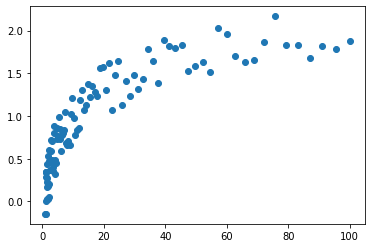

In [ ]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

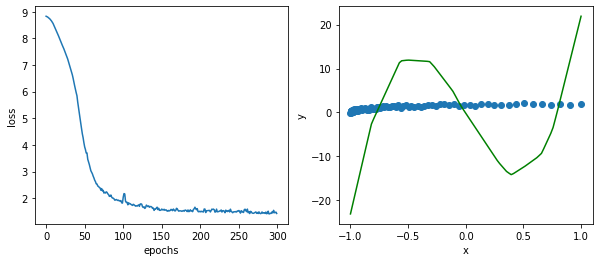

In [ ]:


plot_hist_and_line(hist.history, x, y, model)

## Regressão Exponencial

(100, 1) (100, 1)


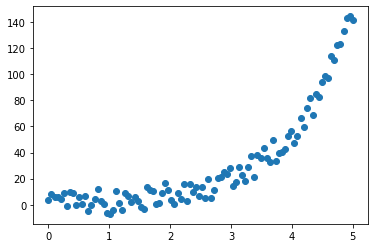

In [ ]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)
print(x.shape, y.shape)

plt.scatter(x, y)

minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

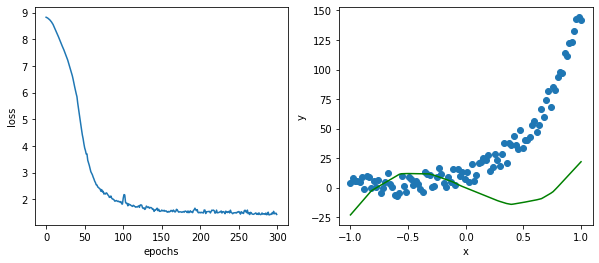

In [ ]:


plot_hist_and_line(hist.history, x, y, model)

# Classificação Binária

## Blobs

(100, 2) (100, 1)


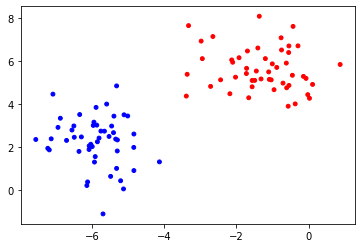

In [ ]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch 1/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 1.0000
Epoch 2/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1536 - accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1501 - accuracy: 1.0000
Epoch 4/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1467 - accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1434 - accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1403 - accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1373 - accuracy: 1.0000
Epoch 8/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1344 - accuracy: 1.0000
Epoch 9/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1316 - accuracy: 1.0000
Epoch 10/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1289 - accuracy: 1.0000
Epoch 11/50
10/10 [

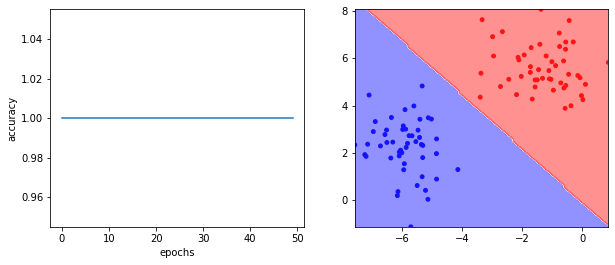

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, activation="sigmoid", input_dim=2),
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

hist = model.fit(x, y, batch_size=10, epochs=50)

plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## 4 Clusters

(500, 2) (500, 1)


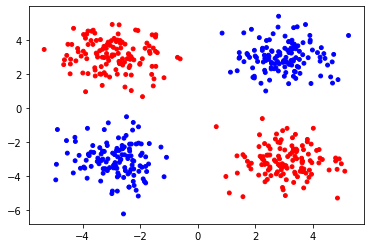

In [ ]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch 1/100
50/50 [==============================] - 0s 2ms/step - loss: 0.9420 - accuracy: 0.4980
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.8366 - accuracy: 0.5040
Epoch 3/100
50/50 [==============================] - 0s 2ms/step - loss: 0.7544 - accuracy: 0.5180
Epoch 4/100
50/50 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5320
Epoch 5/100
50/50 [==============================] - 0s 2ms/step - loss: 0.6399 - accuracy: 0.5600
Epoch 6/100
50/50 [==============================] - 0s 2ms/step - loss: 0.6005 - accuracy: 0.5940
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 0.5698 - accuracy: 0.6080
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: 0.5445 - accuracy: 0.6300
Epoch 9/100
50/50 [==============================] - 0s 2ms/step - loss: 0.5232 - accuracy: 0.6560
Epoch 10/100
50/50 [==============================] - 0s 2ms/step - loss: 0.5077 - accuracy: 0.6600
Epoch 11/

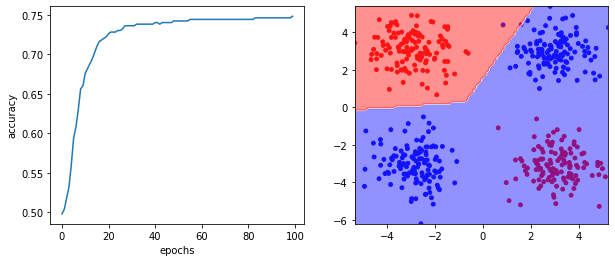

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=2, activation="relu", input_dim=2),
    # tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

hist = model.fit(x, y, batch_size=10, epochs=100)

plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## Círculos

(500, 2) (500, 1)


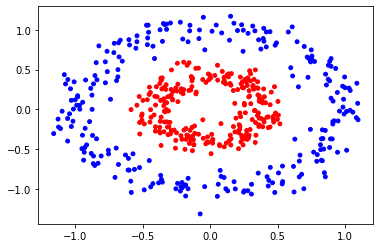

In [ ]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

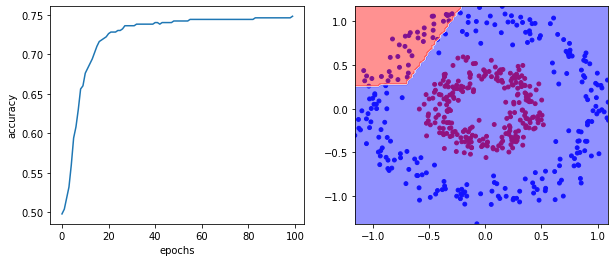

In [ ]:


plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## Moons

(200, 2) (200, 1)


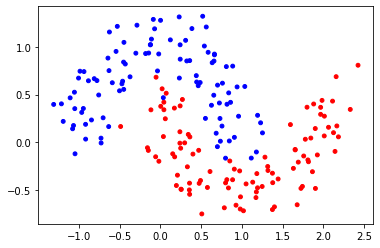

In [ ]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

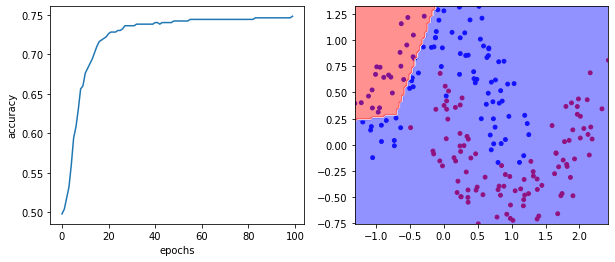

In [ ]:


plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

## Espiral

(200, 2) (200, 1)


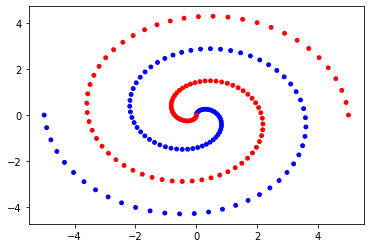

In [ ]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch 1/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5800
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.5900
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6747 - accuracy: 0.5900
Epoch 4/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6719 - accuracy: 0.6300
Epoch 5/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6697 - accuracy: 0.6300
Epoch 6/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6662 - accuracy: 0.6400
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.6400
Epoch 8/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.6600
Epoch 9/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.6750
Epoch 10/200
10/10 [==============================] - 0s 2ms/step - loss: 0.6599 - accuracy: 0.6850
Epoch 11/

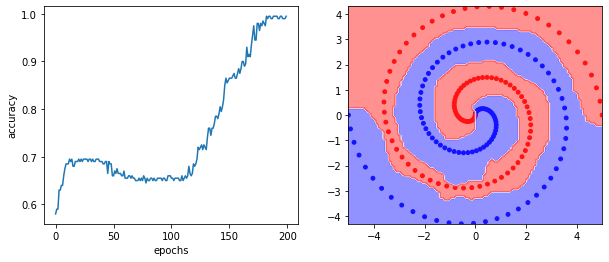

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=30, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=20, activation="relu"),
    tf.keras.layers.Dense(units=20, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

hist = model.fit(x, y, batch_size=20, epochs=200)

plot_hist_and_predictions(hist.history, x, y, model, cmap='bwr')

# Classificação Multiclasse

## 3 Clusters

(300, 2) (300, 1)


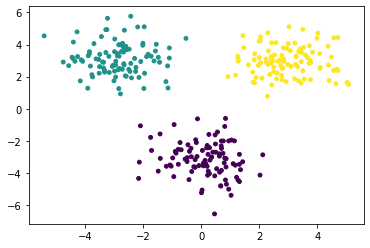

In [ ]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 2.2965 - accuracy: 0.2267
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 2.2065 - accuracy: 0.2333
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 2.1184 - accuracy: 0.2400
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 2.0367 - accuracy: 0.2467
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 1.9585 - accuracy: 0.2567
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 1.8841 - accuracy: 0.2600
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 1.8130 - accuracy: 0.2667
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 1.7457 - accuracy: 0.2733
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 1.6832 - accuracy: 0.3800
Epoch 10/100
10/10 [==============================] - 0s 1ms/step - loss: 1.6226 - accuracy: 0.6200
Epoch 11/

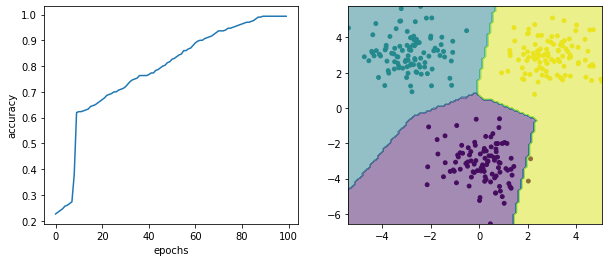

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=3, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

hist = model.fit(x, y, batch_size=30, epochs=100)

plot_hist_and_predictions(hist.history, x, y, model)

## 4 Clusters

(400, 2) (400, 1)


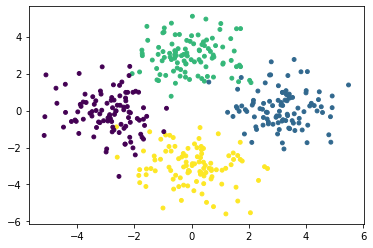

In [ ]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 1.3773 - accuracy: 0.3500
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 1.3572 - accuracy: 0.4200
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 1.3402 - accuracy: 0.4700
Epoch 4/100
4/4 [==============================] - 0s 2ms/step - loss: 1.3242 - accuracy: 0.4600
Epoch 5/100
4/4 [==============================] - 0s 2ms/step - loss: 1.3090 - accuracy: 0.4600
Epoch 6/100
4/4 [==============================] - 0s 2ms/step - loss: 1.2943 - accuracy: 0.4600
Epoch 7/100
4/4 [==============================] - 0s 2ms/step - loss: 1.2806 - accuracy: 0.4600
Epoch 8/100
4/4 [==============================] - 0s 2ms/step - loss: 1.2679 - accuracy: 0.4700
Epoch 9/100
4/4 [==============================] - 0s 2ms/step - loss: 1.2554 - accuracy: 0.4700
Epoch 10/100
4/4 [==============================] - 0s 2ms/step - loss: 1.2426 - accuracy: 0.4700
Epoch 11/100
4/4 [===========

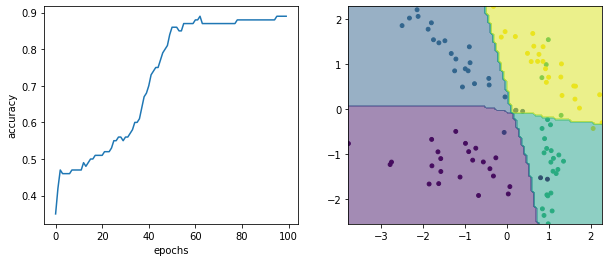

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=20, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=4, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

hist = model.fit(x, y, batch_size=32, epochs=100)

plot_hist_and_predictions(hist.history, x, y, model)

## Espiral - 5 Classes

(500, 2) (500, 1)


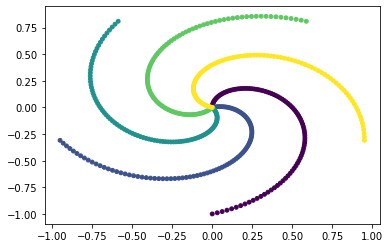

In [ ]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_23 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 505       
Total params: 21,205
Trainable params: 21,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5686 - accuracy: 0.3000
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4726 - accuracy: 0.4040
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3808 - accuracy: 0.4160
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 1.2856 - accuracy:

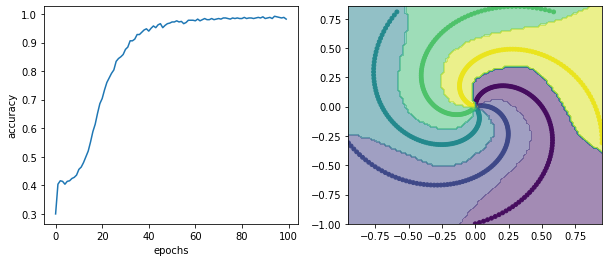

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

hist = model.fit(x, y, batch_size=64, epochs=100)

plot_hist_and_predictions(hist.history, x, y, model)

## Make Classification - 4 Classes

(100, 2) (100, 1)


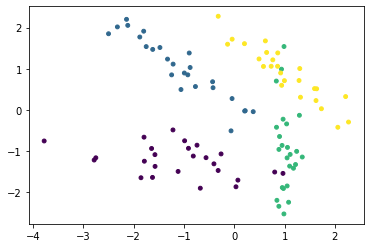

In [ ]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=15)

In [ ]:


plot_hist_and_predictions(hist.history, x, y, model)

## MNIST - 10 classes

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
plot_random_batch(x_train, y_train)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=10, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

list_callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3, verbose=1, restore_best_weights=True),
    ModelCheckpoint("/content/best_model.h5", monitor="val_accuracy", verbose=1, save_best_only=True)
]

hist = model.fit(
    x_train / 255, 
    y_train, 
    batch_size=128, 
    epochs=100, 
    validation_split=0.3, 
    callbacks=list_callbacks
)
model.evaluate(x_test / 255, y_test)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
312/329 [===========================>..] - ETA: 0s - loss: 0.4533 - accuracy: 0.8747
Epoch 00001: val_accuracy improved from -inf to 0.92944, saving model to /content/best_model.h5
329/329 [==============================] - 1s 3ms/step - loss: 0.4449 - accuracy: 0.8768 - val_loss: 0.2559 - val_accuracy: 0.9294
Epoch 2/100
318/329 [===========================>..] - E

[0.08070924878120422, 0.9749000072479248]

In [ ]:
model = tf.keras.models.load_model("/content/best_model.h5")
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


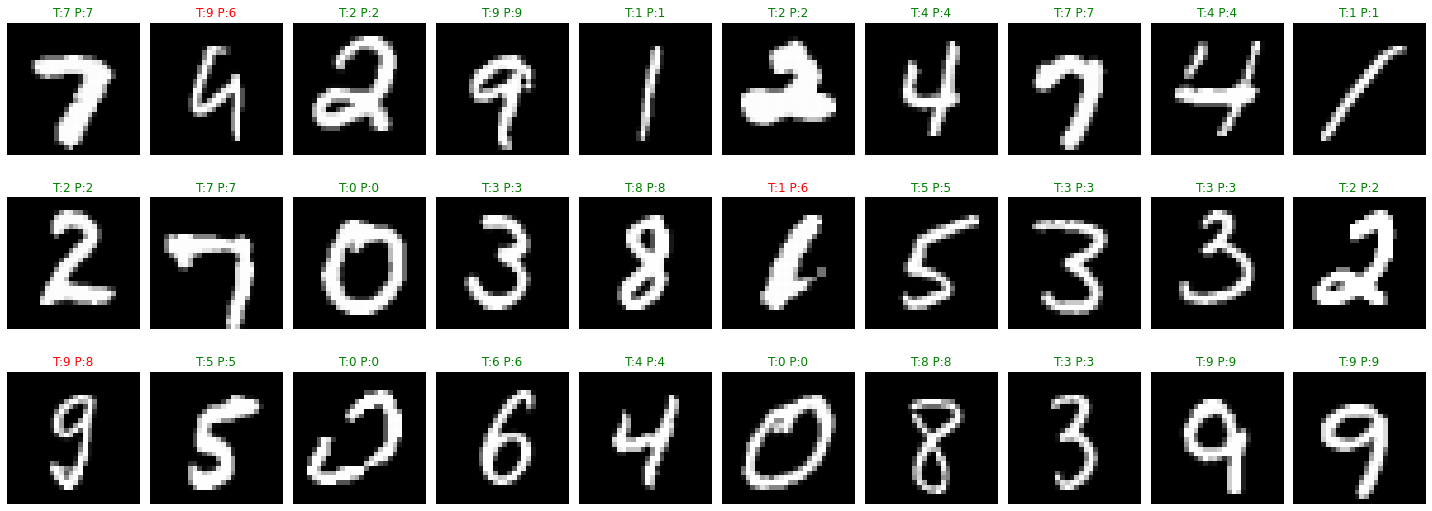

In [ ]:
y_pred = model.predict_classes(x_test / 255)

plot_random_batch(x_test, y_test, y_pred)

# Rede Convolucional

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


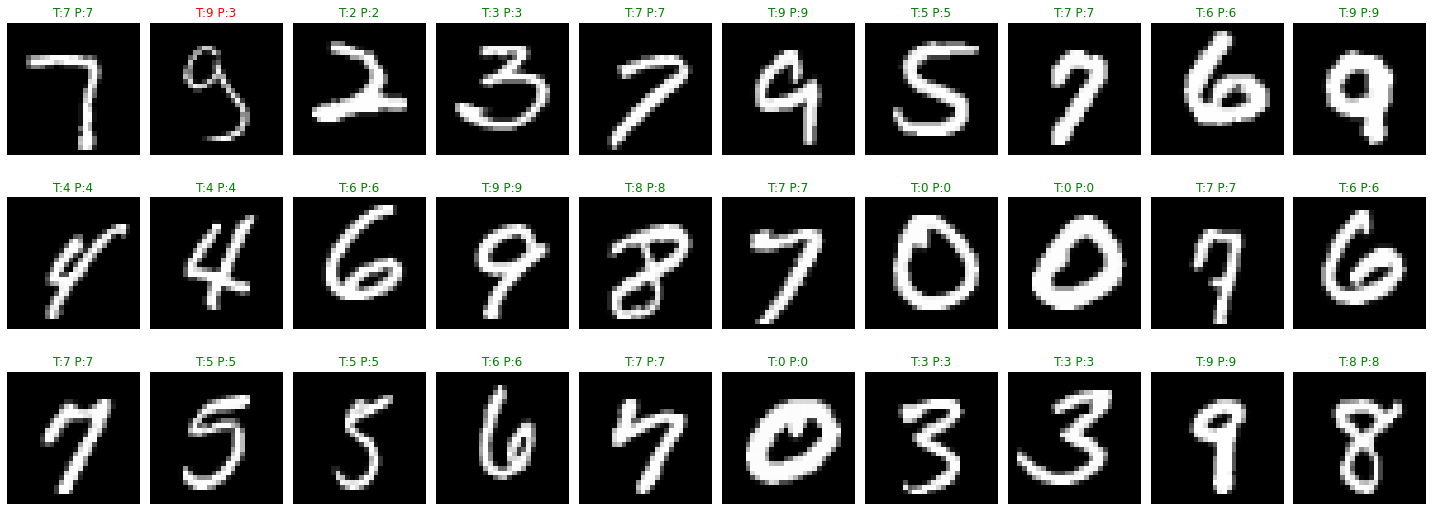

In [ ]:
y_pred = model.predict_classes(x_test / 255)

plot_random_batch(x_test, y_test, y_pred)